# Testing DEMV on _Communities&Crime_ (CRIME) dataset

Data source: [https://archive.ics.uci.edu/ml/datasets/communities+and+crime](https://archive.ics.uci.edu/ml/datasets/communities+and+crime)

- Unprivileged group: `black_people=1 && hisp_people=1`
- Positive label: 100

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from demv import DEMV

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

In [2]:
def prepare_data():
  '''Load the data and apply some pre-processing steps'''
  
  data = pd.read_excel('data2/crime_data_normalized.xlsx', na_values='?')
  data.drop(['state', 'county', 'community', 'communityname',
            'fold', 'OtherPerCap'], axis=1, inplace=True)
  na_cols = data.isna().any()[data.isna().any() == True].index
  data.drop(na_cols, axis=1, inplace=True)
  data = (data - data.mean())/data.std()
  y_classes = np.quantile(data['ViolentCrimesPerPop'].values, [
                          0, 0.2, 0.4, 0.6, 0.8, 1])
  i = 0
  data['ViolentCrimesClass'] = data['ViolentCrimesPerPop']
  for cl in y_classes:
    data.loc[data['ViolentCrimesClass'] <= cl, 'ViolentCrimesClass'] = i*100
    i += 1
  data.drop('ViolentCrimesPerPop', axis=1, inplace=True)
  data['black_people'] = data['racepctblack'] > -0.45
  data['hisp_people'] = data['racePctHisp'] > -0.4
  data['black_people'] = data['black_people'].astype(int)
  data['hisp_people'] = data['hisp_people'].astype(int)
  data.drop('racepctblack', axis=1, inplace=True)
  data.drop('racePctHisp', axis=1, inplace=True)
  return data


In [3]:
data = prepare_data()

In [4]:
data

,population,householdsize,racePctWhite,racePctAsian,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,...,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesClass,black_people,hisp_people
0,1.043350,-0.814793,0.599427,-0.161248,-0.542654,-0.166244,-0.277853,-0.575741,1.059815,0.682833,...,-0.193271,-0.580608,-0.058165,0.500363,0.133666,0.167274,0.940163,300.0,0,1
1,-0.453823,-1.853172,-0.056205,1.418626,-1.058133,0.669623,0.082497,-0.854782,-0.343627,0.682833,...,-1.075534,-0.131778,-0.663550,-0.413220,-0.555677,1.258716,-0.391349,500.0,1,1
2,-0.453823,-0.265063,-0.793790,0.078127,-0.220481,-0.166244,-0.337911,-0.575741,-0.499564,-1.565315,...,0.027294,0.217312,-0.461755,-0.504578,-0.112528,-0.618564,-0.391349,500.0,1,0
3,-0.138629,1.872776,-2.760686,-0.161248,0.552737,0.042723,0.022439,-1.189630,-0.031751,0.682833,...,1.074981,0.067702,-0.007717,-0.413220,0.773770,0.516536,-0.391349,300.0,1,1
4,-0.375024,0.528992,0.804312,-0.304873,-0.284915,-0.793144,-0.638204,-0.352509,-0.343627,0.458018,...,0.578708,-0.081908,-0.613101,-0.230503,-0.703394,-0.618564,-0.391349,100.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,-0.375024,-0.387225,0.476496,-0.161248,0.037258,0.112378,0.082497,-0.687357,-0.265658,0.682833,...,-1.075534,-0.730218,-1.319383,-0.504578,0.232143,-0.487591,-0.391349,200.0,1,1
1990,-0.059830,3.033317,-1.941146,3.237874,1.712562,2.550324,2.364717,-1.580287,-0.031751,0.682833,...,-2.012937,-2.625277,-3.286882,-0.413220,0.675293,0.167274,-0.391349,500.0,1,1
1991,0.806954,-0.570468,-0.261090,-0.544248,-0.478220,0.042723,-0.157736,0.652037,0.825908,0.682833,...,0.413284,0.815752,0.547219,0.134930,0.429099,0.079959,3.395139,400.0,1,1
1992,0.176566,0.284667,0.476496,0.317502,1.003780,1.714457,1.764133,-0.073469,0.202156,0.682833,...,0.027294,-0.181648,-0.663550,-0.321862,0.724532,0.734824,0.524066,300.0,0,1


In [5]:
label = 'ViolentCrimesClass'
groups_condition = {'black_people': 1, 'hisp_people': 1}
sensitive_features = ['black_people', 'hisp_people']
positive_label = 100

In [6]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(n_jobs=-1))
])

## Logistic Regression Bias

In [7]:
model, lr_bias = cross_val(pipeline, data, label, groups_condition, sensitive_features, positive_label=positive_label)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [8]:
print_metrics(lr_bias)

Equalized odds:  0.442  +-  0.132
Disparate impact:  0.09  +-  0.063
Zero one loss:  0.209  +-  0.067
Accuracy score:  0.497  +-  0.027


## DEMV application

In [9]:
demv = DEMV(round_level=1)
demv_data = data.copy()

### Logistic regression DEMV

In [10]:
model, lr_demv = cross_val(pipeline, demv_data, label, groups_condition, sensitive_features, debiaser=demv, positive_label=100)
print_metrics(lr_demv)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Equalized odds:  0.314  +-  0.153
Disparate impact:  0.366  +-  0.163
Zero one loss:  0.169  +-  0.065
Accuracy score:  0.444  +-  0.032


In [11]:
print_metrics(lr_demv)

Equalized odds:  0.314  +-  0.153
Disparate impact:  0.366  +-  0.163
Zero one loss:  0.169  +-  0.065
Accuracy score:  0.444  +-  0.032


## DEMV Evaluation

In [12]:
demv.get_iters()

164

In [13]:
metrics = eval_demv(42, 164, data.copy(), pipeline, label, groups_condition, sensitive_features, positive_label=100)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

##  Blackbox Postprocessing

In [14]:
data = data.sample(frac=1).reset_index(drop=True)

In [15]:
model, blackboxmetrics, pred = cross_val2(pipeline, data, label, groups_condition, sensitive_features, positive_label=positive_label)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2239  0.8125
200.0  0.0937  0.1579
300.0  0.1020  0.4118
400.0  0.1200  0.5333
500.0  0.0101  0.6875

1
          fpr     tpr
100.0  0.0506  0.5000
200.0  0.0779  0.0000
300.0  0.2090  0.4444
400.0  0.2812  0.3810
500.0  0.1132  0.5625


And loss is 0.4750


Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2542  0.7907
200.0  0.0952  0.1667
300.0  0.0909  0.4286
400.0  0.1111  0.5833
500.0  0.0115  0.6667

1
          fpr     tpr
100.0  0.0411  0.6000
200.0  0.0857  0.0000
300.0  0.1967  0.4706
400.0  0.2787  0.4706
500.0  0.0638  0.5806


And loss is 0.4611

[6.84961807e-01 2.99419046e-08 1.03098867e-01 1.42646338e-01
 6.92929580e-02]
[0.43313762 0.04080161 0.34774531 0.10737269 0.07094276]
[0.18563041 0.06295103 0.58520547 0.13580904 0.03040405]
[0.1443792  0.02448095 0.52552738 0.23303178 0.07258068]
[0.05775168 0.00979238 0.18830574 0.16350503 0.58064516]
[6.84961807e-01 9.15479823e-09 3.15038175e-0

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2958  0.6818
200.0  0.1222  0.1600
300.0  0.1383  0.3333
400.0  0.1132  0.2222
500.0  0.0404  0.6875

1
          fpr     tpr
100.0  0.0921  0.3333
200.0  0.0972  0.2308
300.0  0.3182  0.4737
400.0  0.1333  0.2800
500.0  0.1364  0.5789


And loss is 0.5650


Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2742  0.6389
200.0  0.1139  0.1579
300.0  0.1538  0.3500
400.0  0.1348  0.2222
500.0  0.0476  0.6429

1
          fpr     tpr
100.0  0.0959  0.3333
200.0  0.1014  0.2308
300.0  0.3231  0.4706
400.0  0.1379  0.2500
500.0  0.1270  0.5789


And loss is 0.5833

[0.39212905 0.13480662 0.30924245 0.00328947 0.16053241]
[0.32074704 0.11105351 0.35086334 0.01246537 0.20487073]
[0.12735485 0.05275042 0.41666009 0.02960526 0.37362939]
[0.17987097 0.04688926 0.28147563 0.02631579 0.46544834]
[8.87040113e-11 2.64497740e-11 7.14285713e-02 3.38345869e-02
 8.94736842e-01]
[0.39212905 0.05373632 0.43002647 0.01299706

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2597  0.7895
200.0  0.0870  0.2174
300.0  0.1359  0.4167
400.0  0.0737  0.2500
500.0  0.0753  0.6364

1
          fpr     tpr
100.0  0.0769  0.5714
200.0  0.0588  0.1176
300.0  0.2941  0.5294
400.0  0.1875  0.5238
500.0  0.0161  0.6957


And loss is 0.4950


Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2647  0.7941
200.0  0.0854  0.1500
300.0  0.1304  0.4000
400.0  0.0824  0.2353
500.0  0.0741  0.6667

1
          fpr     tpr
100.0  0.0833  0.5000
200.0  0.0656  0.1176
300.0  0.2857  0.4667
400.0  0.1833  0.5556
500.0  0.0179  0.7273


And loss is 0.5000

[4.03860890e-01 5.07903815e-01 7.00279617e-10 8.82352940e-02
 2.81030796e-11]
[3.05139339e-01 4.44860660e-01 1.10386592e-09 2.50000000e-01
 2.50061976e-11]
[5.08565566e-02 1.49143443e-01 1.15409610e-09 5.99999999e-01
 2.00000000e-01]
[8.97468646e-02 1.45547253e-01 8.39354607e-10 5.29411764e-01
 2.35294118e-01]
[4.84348158e-02 9.44223269e-02 3.09282

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2464  0.8108
200.0  0.1236  0.2941
300.0  0.1341  0.4167
400.0  0.0440  0.3333
500.0  0.0538  0.6154

1
          fpr     tpr
100.0  0.0333  0.2500
200.0  0.0952  0.2000
300.0  0.1639  0.4848
400.0  0.2703  0.6500
500.0  0.0448  0.6667


And loss is 0.4600


Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2581  0.7879
200.0  0.1250  0.3333
300.0  0.1233  0.4091
400.0  0.0366  0.3077
500.0  0.0602  0.6667

1
          fpr     tpr
100.0  0.0370  0.2500
200.0  0.1067  0.2000
300.0  0.1481  0.4516
400.0  0.3030  0.6842
500.0  0.0469  0.6190


And loss is 0.4722

[6.12517808e-01 1.20702742e-01 1.42508266e-01 1.24271174e-01
 1.00445890e-08]
[4.14627445e-01 1.68183620e-01 8.10825657e-02 3.36106358e-01
 1.11878084e-08]
[0.2120254  0.08961857 0.41646266 0.19658622 0.08530714]
[0.05980205 0.05790992 0.23284846 0.43289068 0.21654889]
[0.06478555 0.03622153 0.08558583 0.18782143 0.62558565]
[6.12517808e-01 1.56940

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2800  0.6970
200.0  0.1358  0.1852
300.0  0.1222  0.3889
400.0  0.0426  0.3571
500.0  0.0978  0.7500

1
          fpr     tpr
100.0  0.0250  0.6364
200.0  0.0750  0.1818
300.0  0.2838  0.4118
400.0  0.1967  0.3333
500.0  0.1449  0.6364


And loss is 0.5377


Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2609  0.6970
200.0  0.1429  0.2000
300.0  0.1163  0.4375
400.0  0.0449  0.3846
500.0  0.0920  0.7333

1
          fpr     tpr
100.0  0.0294  0.5556
200.0  0.0882  0.2222
300.0  0.3065  0.4000
400.0  0.2115  0.2800
500.0  0.1379  0.5789


And loss is 0.5419

[0.59378871 0.02459669 0.05805201 0.14190826 0.18165434]
[0.47709632 0.01976291 0.10217153 0.16536601 0.23560323]
[0.15974207 0.00661705 0.27937528 0.23068186 0.32358375]
[0.06553521 0.00271468 0.09824186 0.21495877 0.61854948]
[1.02347241e-10 4.65166980e-10 4.25714712e-02 8.59066794e-02
 8.71521849e-01]
[5.93788713e-01 5.75071855e-02 2.29282563e-0

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2000  0.7895
200.0  0.1413  0.3125
300.0  0.1205  0.2000
400.0  0.1379  0.2857
500.0  0.0600  0.8750

1
          fpr     tpr
100.0  0.0127  0.5000
200.0  0.0723  0.3750
300.0  0.1618  0.4348
400.0  0.2609  0.5000
500.0  0.1231  0.6538


And loss is 0.4975


Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.1692  0.7714
200.0  0.1395  0.3571
300.0  0.1299  0.2174
400.0  0.1519  0.2857
500.0  0.0645  0.8571

1
          fpr     tpr
100.0  0.0147  0.4545
200.0  0.0694  0.4286
300.0  0.1525  0.5000
400.0  0.2540  0.5000
500.0  0.1111  0.6400


And loss is 0.4916

[0.77142857 0.01055121 0.05388268 0.13594015 0.02819739]
[0.5        0.04396338 0.19286371 0.14568378 0.11748913]
[0.13043478 0.03211238 0.36625931 0.38537538 0.08581815]
[0.04761905 0.01758535 0.24804177 0.43593194 0.25082189]
[2.20321303e-11 3.52771969e-11 9.49423778e-02 2.93578900e-01
 6.11478722e-01]
[7.71428571e-01 2.79766941e-02 1.24372870e-0

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.3194  0.8478
200.0  0.0714  0.1000
300.0  0.0865  0.2143
400.0  0.0707  0.4211
500.0  0.0707  0.6842

1
          fpr     tpr
100.0  0.0563  0.5000
200.0  0.1029  0.3077
300.0  0.1964  0.4400
400.0  0.2459  0.5000
500.0  0.0735  0.6923


And loss is 0.4774


Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.3077  0.8780
200.0  0.0690  0.1053
300.0  0.0745  0.2500
400.0  0.0667  0.5000
500.0  0.0682  0.6667

1
          fpr     tpr
100.0  0.0625  0.4444
200.0  0.0984  0.3333
300.0  0.2041  0.4167
400.0  0.2679  0.5294
500.0  0.0645  0.6364


And loss is 0.4693

[2.82701454e-01 2.78130408e-01 1.42233755e-01 2.96934383e-01
 7.72254298e-12]
[2.20292215e-01 2.16730274e-01 2.80316552e-01 2.82660959e-01
 1.23438460e-11]
[0.13415231 0.13198318 0.35263393 0.22209634 0.15913424]
[0.04024569 0.03959495 0.15204623 0.52941176 0.23870136]
[2.24765380e-11 1.85835367e-11 1.46956445e-01 2.16506603e-01
 6.36536952e-01]
[2

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2466  0.6500
200.0  0.1313  0.2143
300.0  0.1364  0.2400
400.0  0.1398  0.1500
500.0  0.1010  0.6429

1
          fpr     tpr
100.0  0.0759  0.4286
200.0  0.0779  0.4444
300.0  0.1774  0.3750
400.0  0.1667  0.3846
500.0  0.1515  0.8500


And loss is 0.5477


Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2308  0.6111
200.0  0.1333  0.1818
300.0  0.1481  0.2000
400.0  0.1481  0.1500
500.0  0.1149  0.6429

1
          fpr     tpr
100.0  0.0833  0.5000
200.0  0.0580  0.4444
300.0  0.1636  0.3913
400.0  0.1667  0.4167
500.0  0.1613  0.8750


And loss is 0.5531

[0.42004812 0.41328522 0.00854354 0.13888889 0.01923424]
[0.3878187  0.43036312 0.02796067 0.09090909 0.06294842]
[0.28092877 0.16907123 0.07689183 0.2        0.27310817]
[0.04855726 0.10144274 0.0461351  0.3        0.5038649 ]
[1.62319409e-10 1.47069250e-10 1.09845476e-01 6.95536104e-09
 8.90154516e-01]
[0.42004812 0.35996755 0.07427297 0.12550534

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.1905  0.8158
200.0  0.0808  0.3043
300.0  0.1429  0.5000
400.0  0.0811  0.2727
500.0  0.0521  0.6538

1
          fpr     tpr
100.0  0.0441  0.4444
200.0  0.0781  0.2308
300.0  0.3770  0.5625
400.0  0.1091  0.4545
500.0  0.0833  0.5294


And loss is 0.4724


Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2078  0.8333
200.0  0.0652  0.2857
300.0  0.1556  0.5217
400.0  0.0686  0.2727
500.0  0.0549  0.6364

1
          fpr     tpr
100.0  0.0500  0.5000
200.0  0.0741  0.2500
300.0  0.3774  0.5385
400.0  0.1136  0.4545
500.0  0.0943  0.4615


And loss is 0.4749

[0.42144822 0.49039678 0.02701562 0.03952495 0.02161442]
[0.24082755 0.51832197 0.07718749 0.11292844 0.05073454]
[0.10994301 0.19314699 0.16914128 0.36080953 0.16695919]
[0.04597617 0.04440692 0.11788635 0.52797604 0.26375453]
[2.82293534e-11 4.54545456e-02 2.94715869e-02 4.63535406e-01
 4.61538461e-01]
[4.21448220e-01 2.10069891e-01 3.30018252e-0

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2472  0.8148
200.0  0.0947  0.0952
300.0  0.1494  0.2069
400.0  0.1596  0.2727
500.0  0.1111  0.5882

1
          fpr     tpr
100.0  0.0685  0.5000
200.0  0.0533  0.2500
300.0  0.1613  0.5238
400.0  0.1186  0.6250
500.0  0.1111  0.8500


And loss is 0.5176


Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2716  0.8333
200.0  0.0824  0.1000
300.0  0.1410  0.2222
400.0  0.1628  0.3158
500.0  0.1000  0.5333

1
          fpr     tpr
100.0  0.0606  0.3750
200.0  0.0597  0.1429
300.0  0.1852  0.5500
400.0  0.0980  0.6522
500.0  0.1034  0.9375


And loss is 0.5140

[5.69858350e-01 2.63474983e-01 1.66666667e-01 4.75187411e-11
 1.79709188e-11]
[3.76106511e-01 1.73893489e-01 4.00000000e-01 1.11776041e-10
 5.00000000e-02]
[2.02616302e-01 9.36799941e-02 3.70370370e-01 1.97708295e-10
 3.33333333e-01]
[1.07973161e-01 4.99215758e-02 1.57894737e-01 2.01561951e-10
 6.84210526e-01]
[2.25312467e-11 1.74970028e-11 6.66666

##  Plot

In [16]:
df = prepareplots(metrics,'crime')

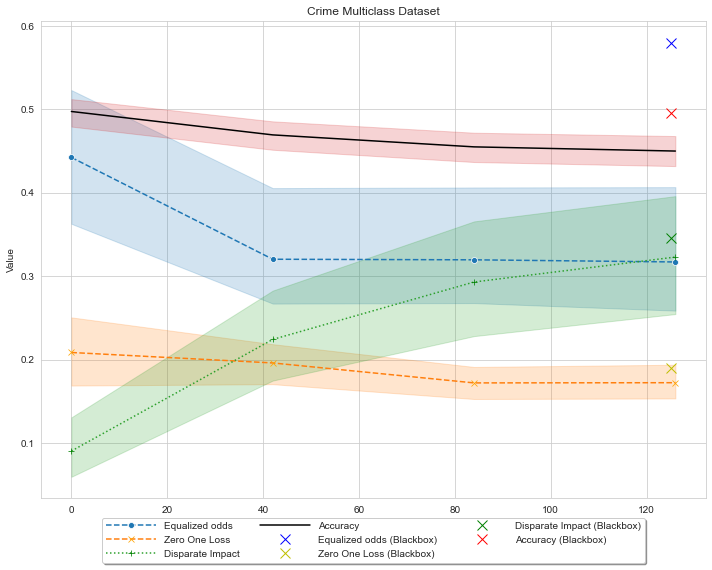

In [17]:
points = preparepoints(blackboxmetrics, 125)

plot_metrics_curves(df, points, title='Crime Multiclass Dataset')


In [18]:
unprivpergentage(data,groups_condition, demv.get_iters())

Dataset size: 1994
Unprivileged group size: 471
Percentage of unprivileged group: 23.620862587763288
Number of iterations: 164


In [19]:
save_metrics('blackbox', 'crime', blackboxmetrics)